## Marginal Ambiguity

In [ ]:
#Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import time
import numpy as np
from scipy.integrate import quad_vec
import scipy.stats as si
import pygad
import torch
from tqdm import tqdm
import random
from scipy.optimize import minimize, differential_evolution
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import UnivariateSpline


In [2]:
# Enable LaTeX fonts in plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

In [ ]:
# Seeds
MASTER_SEED = 42
np.random.seed(MASTER_SEED)
random.seed(MASTER_SEED)


In [4]:
#Simulation parameters
T = 1.0                 # Time horizon (years)
N = 252                 # Number of time steps
dt = T / N              # Time increment
M = 10000                # Number of Monte Carlo simulations

#Interest rate parameters
kappa_r= 0.13                                       # Speed of mean reversion for interest rate                             # Escobar
varphi_r=0.0025                                     # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
print("varphi_r/kappa_r: ", varphi_r / kappa_r)     # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
sigma_r= 0.0566                                     # Volatility of the interest rate                                       # Escobar
r0 = varphi_r / kappa_r                             # Initial interest rate                                                 # Escobar

#Bond parameters
lambda_r = -0.1132                                  # Risk premium on interest rate                                         # Escobar
T_tilde = T                                         # Bond maturity

#Stock and variance 

# Parameters for Heston volatility process
kappa_v = 2.8278                                    # Speed of mean reversion for variance                                  # Escobar
varphi_v= 0.0563                                    # varphi_v/kappa_v is the long-run variance                             # Escobar
print("varphi_v/kappa_v: ", varphi_v / kappa_v)     # varphi_v/kappa_v is the long-run variance                             # Escobar
sigma_v = 0.2941                                    # Volatility of variance process                                        # Escobar
V0 = varphi_v / kappa_v                             # Initial variance                                                      # Escobar    
rho = -0.23                                         # Correlation between stock and variance shocks                         # Escobar                                  
lambda_v= -6.6932                                   # Risk premium on variance                                              # Escobar                 

# Parameters for stock price process
S0 = 100                                            # Initial stock price                                                   # Escobar
lambda_s = 2.2472                                   # Risk premium on diffusive risk                                        # Escobar                        
nu=-0.5973                                          # Factor loading stock and rate                                         # Escobar 
lambda_j = 12.3                                     # Jump intensity                                                        # Pan
lambda_j_q = lambda_j*2                             # Jump intensity Q                                                      # Liu and Pan
mu= -0.10                                           # Jump amplitude                                                        # Liu and Pan

# Parameters for jump process
lambda_J = 0.5                                      # Jump frequency                                                        # Liu and Pan

# Parameters for option pricing 
num_K= 9                                            # Number of strikes         

# General parameters
gamma= 3                                            # Risk aversion parameter                                              # Liu and Pan
num_options= 5

#Sensitivity parameters
vals = 10 # Number of values for the sensitivity analysis
num_runs = 10  # Number of runs of GA per sensitivity analysis


varphi_r/kappa_r:  0.019230769230769232
varphi_v/kappa_v:  0.019909470259565742


In [5]:
# Function for b(T-t)
def b_func(T_tilde, t, kappa_r, lambda_r):
    xi = np.sqrt((kappa_r + lambda_r) ** 2 + 2 * sigma_r ** 2)
    num = 2 * (np.exp(xi * (T_tilde - t)) - 1)
    den = 2 * xi + (xi + kappa_r + lambda_r) * (np.exp(xi * (T_tilde - t)) - 1)
    return num / den

In [6]:
#INCLUDING AMBIGUITY

# Compute k1, k2, and delta based on the parameters
def compute_k1_k2_k3_vol_ambiguity(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j, phi_v, phi_s):
    k1_v = kappa_v - ((lambda_v *( 1-(phi_v + gamma)) * sigma_v) / (phi_v + gamma)) 
    k3_v=((lambda_s**2) * (1 - gamma)) / (phi_s + gamma) +((lambda_v**2) * (1 - gamma)) / (phi_v + gamma) +lambda_j_q*(gamma*(lambda_j/lambda_j_q)**(1/gamma)+(1-gamma)-(lambda_j/lambda_j_q))
    k4_v=(sigma_v**2 * (1- (phi_v + gamma)))/((1-gamma) *(phi_v + gamma))
    k2_v = np.sqrt(k1_v**2 - k3_v*k4_v)
    return k1_v, k2_v, k3_v

def compute_k1_k2_k3_rate_ambiguity(gamma, lambda_r, sigma_r, kappa_r, phi_r):
    k1_r = kappa_r - ((1 - (phi_r + gamma)) *(lambda_r))/ (gamma+phi_r)
    k3_r=2*(1-gamma)+(lambda_r**2*(1-gamma))/((phi_r+gamma)*sigma_r**2)
    k4_r=(sigma_r**2 * (1-(phi_r + gamma)))/((1-gamma)*(phi_r + gamma))
    k2_r = np.sqrt(k1_r**2 - k3_r*k4_r)
    return k1_r, k2_r, k3_r

# Compute the time-dependent function H(tau)
def H_v(tau, k1_v, k2_v, k3_v):
    denominator = 2 * k2_v + (k1_v + k2_v) * (np.exp(k2_v * tau) - 1)
    H_v_star = ((np.exp(k2_v*tau)-1) / denominator)*k3_v
    return H_v_star

def H_r(tau, k1_r, k2_r, k3_r):
    denominator = 2 * k2_r + (k1_r + k2_r) * (np.exp(k2_r * tau) - 1)
    H_r_star = ((np.exp(k2_r*tau)-1) / denominator)*k3_r
    return H_r_star

In [7]:
def e_s_func(phi_s, lambda_s, gamma, V):
    return phi_s * lambda_s / (gamma + phi_s) * np.sqrt(V)

def e_r_func(phi_r, lambda_r, sigma_r, gamma, r, tau, k1_r, k2_r, k3_r):
    H1_c = H_r(tau, k1_r, k2_r, k3_r) 
    term1 = lambda_r / (sigma_r**2 * (gamma + phi_r))
    term2 = 1 / ((1 - gamma) * (gamma + phi_r)) * H1_c
    return phi_r * (term1 + term2) * sigma_r * np.sqrt(r)

def e_v_func(phi_v, lambda_v, sigma_v, gamma, V, tau, k1_v, k2_v, k3_v):
    H2_c = H_v(tau, k1_v, k2_v, k3_v)
    term1 = lambda_v / (gamma + phi_v)
    term2 = sigma_v / ((1 - gamma) * (gamma + phi_v)) * H2_c
    return phi_v * (term1 + term2) * np.sqrt(V) 

In [8]:
print("Return on stock: ", r0+lambda_v*rho*V0+lambda_s*np.sqrt(1-rho**2)*V0+nu*lambda_r*r0+mu*(lambda_j-lambda_j_q)*V0)
print("Return on bond: ", r0-lambda_r*b_func(1,0,kappa_r,lambda_r)*r0)

Return on stock:  0.11921014430729271
Return on bond:  0.021388365884807477


In [9]:
# Functions for simulation of model processes and calculation of option prices and greeks

sqrt_1_minus_rho2 = np.sqrt(1 - rho**2)

dW_r = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
dW_v = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
dW_s = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
N_J = np.random.poisson(lambda_J * dt, size=(M, N + 1))

# === Simulation ===

def simulation(S0, V0, r0, dW_r, dW_v, dW_s, N_J):

    # Initialize arrays
    S_paths = np.zeros((M, N + 1))
    V_paths = np.zeros((M, N + 1))
    r_paths = np.zeros((M, N + 1))
    B = np.zeros((M, N + 1))
    M_t = np.zeros((M, N + 1))

    sqrt_1_minus_rho2 = np.sqrt(1 - rho ** 2)

    # Initial values
    S_paths[:, 0] = S0
    V_paths[:, 0] = V0
    r_paths[:, 0] = r0
    B[:, 0] = 1
    M_t[:, 0] = 1


    # Store means
    mean_S = [np.mean(S0)]
    mean_V = [np.mean(V0)]
    mean_r = [np.mean(r0)]
    mean_M = [1.0]
    mean_B = [1.0]

    for j in range(1, N + 1):
        S_prev = S_paths[:, j - 1]
        V_prev = V_paths[:, j - 1]
        r_prev = r_paths[:, j - 1]

        # CIR (interest rate)
        r_new = r_prev + (varphi_r - kappa_r * r_prev) * dt + sigma_r * np.sqrt(np.maximum(r_prev, 0)) * dW_r[:, j]
        r_new = np.maximum(r_new, 0)

        # Heston (volatility)
        V_new = V_prev + (varphi_v - kappa_v * V_prev) * dt + sigma_v * np.sqrt(np.maximum(V_prev, 0)) * dW_v[:, j]
        V_new = np.maximum(V_new, 0)

        # Stock diffusion
        diffusion = np.sqrt(V_prev) * (rho * dW_v[:, j] + sqrt_1_minus_rho2 * dW_s[:, j]) * S_prev \
                    + nu * sigma_r * np.sqrt(r_prev) * dW_r[:, j] * S_prev

        # Jump component
        jump_term = S_prev * mu * (N_J[:, j] - lambda_j * V_prev * dt)

        # Drift
        drift = (
            r_prev
            + lambda_v * rho * V_prev
            + lambda_s * sqrt_1_minus_rho2 * V_prev
            + nu * lambda_r * r_prev
            + mu * (lambda_j - lambda_j_q) * V_prev
        ) * S_prev * dt

        # Stock price update
        S_new = S_prev + drift + diffusion + jump_term

        # Money market account
        M_t[:, j] = M_t[:, j - 1] * np.exp(r_prev * dt)

        # Bond process
        t_curr = j * dt
        b_T_t = b_func(T_tilde, t_curr, kappa_r, lambda_r)
        drift_B = (r_prev - lambda_r * b_T_t * r_prev) * B[:, j - 1] * dt
        diffusion_B = -b_T_t * sigma_r * np.sqrt(r_prev) * B[:, j - 1] * dW_r[:, j]
        B[:, j] = B[:, j - 1] + drift_B + diffusion_B

        # Store new values
        S_paths[:, j] = S_new
        V_paths[:, j] = V_new
        r_paths[:, j] = r_new

        mean_S.append(np.mean(S_new))
        mean_V.append(np.mean(V_new))
        mean_r.append(np.mean(r_new))
        mean_M.append(np.mean(M_t[:, j]))
        mean_B.append(np.mean(B[:, j]))


    return mean_S, mean_V, mean_r, mean_M, mean_B, dW_s, dW_v, dW_r, N_J


In [10]:
# === Fixed simulate_paths_ambiguity with numerical safeguards ===

def simulate_paths_ambiguity(S0, V0, r0, phi_v_val, phi_r_val, phi_s_val, dW_s, dW_v, dW_r, N_J):

    # Initialize arrays
    S_paths = np.zeros((M, N + 1))
    V_paths = np.zeros((M, N + 1))
    r_paths = np.zeros((M, N + 1))
    B = np.zeros((M, N + 1))
    M_t = np.zeros((M, N + 1))
    dW_r_amb = np.zeros((M, N + 1))
    dW_v_amb = np.zeros((M, N + 1))
    dW_s_amb = np.zeros((M, N + 1))

    sqrt_1_minus_rho2 = np.sqrt(1 - rho ** 2)

    # Initial values
    S_paths[:, 0] = S0
    V_paths[:, 0] = V0
    r_paths[:, 0] = r0
    B[:, 0] = 1
    M_t[:, 0] = 1

    # Store means
    mean_S = [np.mean(S0)]
    mean_V = [np.mean(V0)]
    mean_r = [np.mean(r0)]
    mean_M = [1.0]
    mean_B = [1.0]

    for j in range(1, N + 1):
        S_prev = S_paths[:, j - 1]
        V_prev = V_paths[:, j - 1]
        r_prev = r_paths[:, j - 1]

        tau = (N - j) * dt

        # Parameter computation
        k1_v, k2_v, k3_v = compute_k1_k2_k3_vol_ambiguity(gamma, lambda_v, lambda_s, sigma_v,
                                                          kappa_v, lambda_j_q, lambda_j, phi_v_val, phi_s_val)
        k1_r, k2_r, k3_r = compute_k1_k2_k3_rate_ambiguity(gamma, lambda_r, sigma_r, kappa_r, phi_r_val)

        e_r = e_r_func(phi_r_val, lambda_r, sigma_r, gamma, r_prev, tau, k1_r, k2_r, k3_r)
        e_v = e_v_func(phi_v_val, lambda_v, sigma_v, gamma, V_prev, tau, k1_v, k2_v, k3_v)  
        e_s = e_s_func(phi_s_val, lambda_s, gamma, V_prev)

        dW_s_amb[:, j] = dW_s[:, j] + e_s * dt
        dW_v_amb[:, j] = dW_v[:, j] + e_v * dt
        dW_r_amb[:, j] = dW_r[:, j] + e_r * dt

        # CIR (interest rate)
        r_new = r_prev + (varphi_r - kappa_r * r_prev - sigma_r * np.sqrt(np.maximum(r_prev, 0)) * e_r) * dt + sigma_r * np.sqrt(np.maximum(r_prev, 0)) * dW_r_amb[:, j]
        r_new = np.maximum(r_new, 0)


        # Heston (volatility)
        V_new = V_prev + (varphi_v - kappa_v * V_prev - sigma_v * np.sqrt(np.maximum(V_prev, 0)) * e_v) * dt + sigma_v * np.sqrt(np.maximum(V_prev, 0)) * dW_v_amb[:, j]
        V_new = np.maximum(V_new, 0)

        # Stock diffusion
        diffusion = np.sqrt(V_prev) * (rho * dW_v_amb[:, j] + sqrt_1_minus_rho2 * dW_s_amb[:, j]) * S_prev \
                    + nu * sigma_r * np.sqrt(r_prev) * dW_r_amb[:, j] * S_prev


        # Jump component
        jump_term = S_prev * mu * (N_J[:, j] - lambda_j * V_prev * dt)

        # Drift
        drift = (
            r_prev
            + lambda_v * rho * V_prev
            + lambda_s * sqrt_1_minus_rho2 * V_prev
            + nu * lambda_r * r_prev
            - np.sqrt(np.maximum(V_prev, 0)) * rho * e_v
            - np.sqrt(np.maximum(V_prev, 0)) * sqrt_1_minus_rho2 * e_s
            - nu * sigma_r * np.sqrt(np.maximum(r_prev, 0)) * e_r
            + mu * (lambda_j - lambda_j_q) * V_prev
        ) * S_prev * dt

        # Stock price update
        S_new = S_prev + drift + diffusion + jump_term

        # Money market
        M_t[:, j] = M_t[:, j - 1] * np.exp(r_prev * dt)

        # Bond process
        t_curr = j * dt
        b_T_t = b_func(T_tilde, t_curr, kappa_r, lambda_r)
        drift_B = (r_prev - lambda_r * b_T_t * r_prev) * B[:, j - 1] * dt
        diffusion_B = -b_T_t * sigma_r * np.sqrt(r_prev) * B[:, j - 1] * dW_r_amb[:, j]
        B[:, j] = B[:, j - 1] + drift_B + diffusion_B

        # Store new values
        S_paths[:, j] = S_new
        V_paths[:, j] = V_new
        r_paths[:, j] = r_new

        mean_S.append(np.mean(S_new))
        mean_V.append(np.mean(V_new))
        mean_r.append(np.mean(r_new))
        mean_M.append(np.mean(M_t[:, j]))
        mean_B.append(np.mean(B[:, j]))

    return mean_S, mean_V, mean_r, mean_M, mean_B, dW_s_amb, dW_v_amb, dW_r_amb, N_J



In [11]:
# Compute k1, k2, and delta based on the parameters
def compute_k1_k2_k3_vol(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j):
    k1_v = kappa_v - (1 - gamma) / gamma * (lambda_v* sigma_v) 
    k3_v=(lambda_v**2 + lambda_s**2) * ((1 - gamma) / (gamma))+lambda_j_q*(gamma*(lambda_j/lambda_j_q)**(1/gamma)+(1-gamma)-(lambda_j/lambda_j_q))
    k4_v=sigma_v**2/gamma
    k2_v = np.sqrt(k1_v**2 - k3_v*k4_v)
    return k1_v, k2_v, k3_v

def compute_k1_k2_k3_rate(gamma, lambda_r, sigma_r, kappa_r):
    k1_r = kappa_r - ((1 - gamma) *(lambda_r))/ gamma 
    k3_r=2*(1-gamma)+(lambda_r**2*(1-gamma))/(gamma*sigma_r**2)
    k4_r=sigma_r**2/gamma
    k2_r = np.sqrt(k1_r**2 - k3_r*k4_r)
    return k1_r, k2_r, k3_r

def theta_cal(gamma, lambda_s, lambda_v, lambda_r, sigma_v, sigma_r, k1_r, k2_r, k3_r,k1_v, k2_v, k3_v, mu, lambda_j, lambda_j_q, tau):
    theta_s=lambda_s/gamma
    theta_v=lambda_v/gamma+1/gamma*sigma_v*H_v(tau, k1_v, k2_v, k3_v)
    theta_r=lambda_r/(sigma_r**2*gamma)+1/gamma*H_r(tau, k1_r, k2_r, k3_r)
    theta_N=1/mu*((lambda_j/lambda_j_q)**(1/gamma)-1)
    return theta_s, theta_v, theta_r, theta_N

def theta_cal_ambiguity(gamma, lambda_s, lambda_v, lambda_r, sigma_v, sigma_r, k1_r, k2_r, k3_r,k1_v, k2_v, k3_v, mu, lambda_j, lambda_j_q, tau, phi_v, phi_r, phi_s):
    theta_s=lambda_s/(gamma + phi_s)
    theta_s_myopic=lambda_s/(gamma + phi_s)
    theta_v=lambda_v/(gamma + phi_v)+(1 - (gamma + phi_v))/((1-gamma)*(gamma + phi_v))*sigma_v*H_v(tau, k1_v, k2_v, k3_v)
    theta_v_myopic = lambda_v/(gamma + phi_v)
    theta_v_nonmyopic = (1 - (gamma + phi_v))/((1-gamma)*(gamma + phi_v))*sigma_v*H_v(tau, k1_v, k2_v, k3_v)
    theta_r=lambda_r/(sigma_r**2*(phi_r + gamma))+(1 - (gamma + phi_r))/((1-gamma)*(gamma + phi_r))*H_r(tau, k1_r, k2_r, k3_r)
    theta_r_myopic = lambda_r/(sigma_r**2*(phi_r + gamma))
    theta_r_nonmyopic = (1 - (gamma + phi_r))/((1-gamma)*(gamma + phi_r))*H_r(tau, k1_r, k2_r, k3_r)
    theta_N=1/mu*((lambda_j/lambda_j_q)**(1/gamma)-1)
    return theta_s, theta_v, theta_r, theta_N, theta_v_myopic, theta_v_nonmyopic, theta_r_myopic, theta_r_nonmyopic, theta_s_myopic

def pi_calc(theta_s, theta_v, theta_r, theta_N, A1_1, A2_1, A3_1, A4_1,A1_2, A2_2, A3_2, A4_2 ,T_tilde,t,kappa_r,lambda_r, mu,rho, nu):
    b_val = float(b_func(T_tilde, t, kappa_r, lambda_r))
    
    # Construct A matrix using sensitivities at specific (m, t, k)
    A = np.array([
    [np.sqrt(1 - rho**2), 0, A1_1/10, A1_2/10],
    [nu, -b_val*100, A2_1/10, A2_2/10],
    [rho, 0, A3_1/10, A3_2/10],
    [mu / (1 + mu), 0, A4_1/10, A4_2/10]])

    theta = np.array([theta_s, theta_r, theta_v, theta_N], dtype=float)

    # --- Normalize A row-wise and scale theta accordingly ---
    row_norms = np.linalg.norm(A, axis=1, keepdims=True)
    A = A / row_norms
    theta = theta / row_norms.squeeze()

    try:
        pi = np.linalg.solve(A, theta)
    except np.linalg.LinAlgError:
        pi = np.linalg.pinv(A) @ theta

    pi_s = pi[0]
    pi_b = pi[1]
    pi_o1 = pi[2]
    pi_o2 = pi[3]
    pi_mm = 1 - pi_s - pi_b - pi_o1 - pi_o2

    return pi_s, pi_b, pi_o1, pi_o2, pi_mm

In [12]:
def simulate_and_store_paths(S0, V0, r0):
    print("[Step 1] Simulating market paths once...")
    paths = simulation(S0, V0, r0)
    return paths

def simulate_and_store_paths_ambiguity(S0, V0, r0, phi_v_val, phi_r_val, phi_s_val):
    print("[Step 1] Simulating market paths once...")
    paths_ambiguity = simulate_paths_ambiguity(S0, V0, r0, phi_v_val, phi_r_val, phi_s_val)
    return paths_ambiguity


def simulate_wealth(S_np, V_np, r_np, M_t, B_np, dW_s, dW_v, dW_r, N_J
):

    N_sim = len(S_np) - 1
    dt = T / N_sim

    # Initialize wealth vectors
    X_opt = 1
    X_6040 = 1

    # Compute constants and risk premia
    k1_v, k2_v, k3_v = compute_k1_k2_k3_vol(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j)
    k1_r, k2_r, k3_r = compute_k1_k2_k3_rate(gamma, lambda_r, sigma_r, kappa_r)

    theta_s, theta_v, theta_r, theta_N = theta_cal(
        gamma, lambda_s, lambda_v, lambda_r, sigma_v, sigma_r,
        k1_r, k2_r, k3_r, k1_v, k2_v, k3_v,
        mu, lambda_j, lambda_j_q, tau
    )

    pi_s_6040, pi_b_6040 = 0.6, 0.4

    # Simulate wealth paths
    for t in range(N):
        
        V_t = np.maximum(V_np[t], 0)
        r_t = np.maximum(r_np[t], 0)

        sqrt_V_t = np.sqrt(V_t)
        sqrt_r_t = np.sqrt(r_t)

        dW_s_t = dW_s[:, t]
        dW_v_t = dW_v[:, t]
        dW_r_t = dW_r[:, t]
        dN_t = N_J[:, t]

        drift_opt = (
            r_t * dt +
            theta_s * (lambda_s * V_t * dt + sqrt_V_t * dW_s_t) +
            theta_v * (lambda_v * V_t * dt + sqrt_V_t * dW_v_t) +
            theta_r * (lambda_r * r_t * dt + sigma_r * sqrt_r_t * dW_r_t) +
            theta_N * ((lambda_j - lambda_j_q) * V_t * dt + (dN_t - lambda_j * V_t * dt))
        )

        dS_rel = (S_np[t + 1] - S_np[t]) / S_np[t]
        dB_rel = (B_np[t + 1] - B_np[t]) / B_np[t]
        drift_6040 = pi_s_6040 * dS_rel + pi_b_6040 * dB_rel

        X_opt *= (1 + drift_opt)
        X_6040 *= (1 + drift_6040)

    return X_opt, X_6040



In [ ]:

def simulate_wealth_ambiguity(
    S_np, V_np, r_np, M_t, B_np, dW_s_np, dW_v_np, dW_r_np, N_J, phi_s, phi_v, phi_r
):

    tau = 1/12

    N_sim = len(S_np) - 1
    dt = T / N_sim

    # Initialize wealth vectors
    X_opt = 1
    X_6040 = 1

    pi_s_6040, pi_b_6040 = 0.6, 0.4

    k1_v, k2_v, k3_v = compute_k1_k2_k3_vol_ambiguity(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j, phi_v, phi_s)
    k1_r, k2_r, k3_r = compute_k1_k2_k3_rate_ambiguity(gamma, lambda_r, sigma_r, kappa_r, phi_r)

    theta_s, theta_v, theta_r, theta_N, _, _, _, _, _ = theta_cal_ambiguity(gamma, lambda_s, lambda_v, lambda_r, sigma_v, sigma_r, k1_r, k2_r, k3_r,k1_v, k2_v, k3_v, mu, lambda_j, lambda_j_q, tau, phi_v, phi_r, phi_s)
    
    for t in range(N_sim):
        
        V_t = np.maximum(V_np[t], 0)
        r_t = np.maximum(r_np[t], 0)

        sqrt_V_t = np.sqrt(V_t)
        sqrt_r_t = np.sqrt(r_t)

        dW_s_t = dW_s_np[:, t]
        dW_v_t = dW_v_np[:, t]
        dW_r_t = dW_r_np[:, t]
        dN_t = N_J[:, t]

        e_r = e_r_func(phi_r, lambda_r, sigma_r, gamma, r_t, tau, k1_r, k2_r, k3_r)  
        e_v = e_v_func(phi_v, lambda_v, sigma_v, gamma, V_t, tau, k1_v, k2_v, k3_v)  
        e_s = e_s_func(phi_s, lambda_s, gamma, V_t)  
        

        drift_opt = (
            r_t * dt +
            theta_s * (lambda_s * V_t * dt - sqrt_V_t* e_s * dt + sqrt_V_t * dW_s_t) +
            theta_v * (lambda_v * V_t * dt - sqrt_V_t * e_v * dt + sqrt_V_t * dW_v_t) +
            theta_r * (lambda_r * r_t * dt - sigma_r*sqrt_r_t * e_r + sigma_r * sqrt_r_t * dW_r_t) +
            theta_N * ((lambda_j - lambda_j_q) * V_t * dt + (dN_t - lambda_j * V_t * dt))
        )
        
        dS_rel = (S_np[t + 1] - S_np[t]) / S_np[t]
        dB_rel = (B_np[t + 1] - B_np[t]) / B_np[t]
        drift_6040 = pi_s_6040 * dS_rel + pi_b_6040 * dB_rel

        X_opt *= (1 + drift_opt)
        X_6040 *= (1 + drift_6040)

    return X_opt, X_6040


In [ ]:
T_tilde = 1
t_curr=T_tilde - 1/12
tau = T_tilde - t_curr

pi_s_vals     = np.linspace(0, 4, 100)   
pi_r_vals     = np.linspace(0, 4, 100)   
pi_v_vals     = np.linspace(0, 4, 100)    

In [ ]:
#Ambiguity parameters
phi_r = 4
phi_v = 4
phi_s = 4

Sweeping phi_s: 100%|██████████| 100/100 [00:00<00:00, 93206.76it/s]


Sweeping phi_v: 100%|██████████| 100/100 [00:00<00:00, 118316.05it/s]


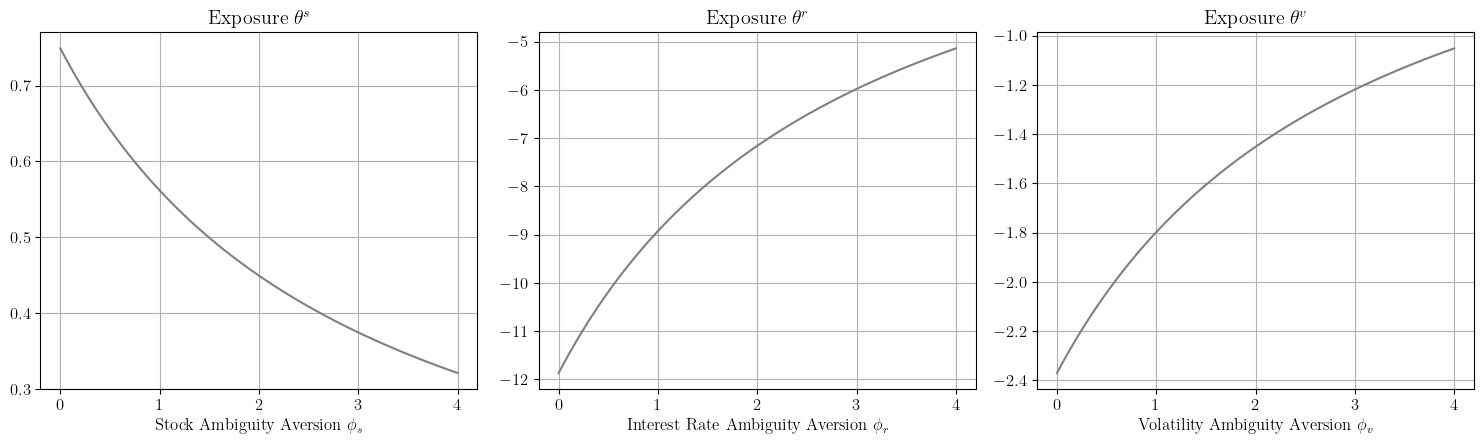

In [ ]:
style_dict = {
    "theta_s": {"color": "grey", "linestyle": "-", "label": r"$\theta_s$"},
    "theta_r": {"color": "grey", "linestyle": "-", "label": r"$\theta_r$"},
    "theta_v": {"color": "grey", "linestyle": "-", "label": r"$\theta_v$"},
    "theta_v_myopic": {"color": "black", "linestyle": "--", "label": r"$\theta_v^{myopic}$"},
    "theta_v_nonmyopic": {"color": "black", "linestyle": "-.", "label": r"$\theta_v^{non-myopic}$"},
    "theta_r_myopic": {"color": "black", "linestyle": "--", "label": r"$\theta_r^{myopic}$"},
    "theta_r_nonmyopic": {"color": "black", "linestyle": "-.", "label": r"$\theta_r^{non-myopic}$"},
    "theta_s_myopic": {"color": "black", "linestyle": "--", "label": r"$\theta_s^{myopic}$"},
}

# Parameter sweep setup
sweep_config = {
    "phi_s": (pi_s_vals, r"Stock Ambiguity Aversion $\phi_s$", r"Exposure $\theta^s$"),
    "phi_r": (pi_r_vals, r"Interest Rate Ambiguity Aversion $\phi_r$", r"Exposure $\theta^r$"),
    "phi_v": (pi_v_vals, r"Volatility Ambiguity Aversion $\phi_v$", r"Exposure $\theta^v$"),
}

# Initialize results
results = {}

# Sweep through each phi parameter
for param_name, (param_vals, _, title) in sweep_config.items():
    theta_s_opt = []
    theta_r_opt = []
    theta_v_opt = []
    theta_v_opt_myopic = []
    theta_v_opt_nonmyopic = []
    theta_r_opt_myopic = []
    theta_r_opt_nonmyopic = []
    thera_s_opt_myopic = []

    for val in tqdm(param_vals, desc=f"Sweeping {param_name}"):
        # Override the relevant phi value
        phi_s_val = val if param_name == "phi_s" else 0
        phi_r_val = val if param_name == "phi_r" else 0
        phi_v_val = val if param_name == "phi_v" else 0

        # Compute thetas
        k1_v, k2_v, k3_v = compute_k1_k2_k3_vol_ambiguity(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j, phi_v_val, phi_s_val)
        k1_r, k2_r, k3_r = compute_k1_k2_k3_rate_ambiguity(gamma, lambda_r, sigma_r, kappa_r, phi_r_val)

        theta_s, theta_v, theta_r, theta_N, theta_v_myopic, theta_v_nonmyopic, theta_r_myopic, theta_r_nonmyopic, theta_s_myopic = theta_cal_ambiguity(
            gamma, lambda_s, lambda_v, lambda_r,
            sigma_v, sigma_r,
            k1_r, k2_r, k3_r,
            k1_v, k2_v, k3_v,
            mu, lambda_j, lambda_j_q, tau,
            phi_v_val, phi_r_val, phi_s_val
        )

        theta_s_opt.append(theta_s)
        theta_r_opt.append(theta_r)
        theta_v_opt.append(theta_v)
        theta_v_opt_myopic.append(theta_v_myopic)
        theta_v_opt_nonmyopic.append(theta_v_nonmyopic)
        theta_r_opt_myopic.append(theta_r_myopic)
        theta_r_opt_nonmyopic.append(theta_r_nonmyopic)
        thera_s_opt_myopic.append(theta_s_myopic)

    results[param_name] = {
        "vals": param_vals,
        "theta_s": theta_s_opt,
        "theta_r": theta_r_opt,
        "theta_v": theta_v_opt, 
        "theta_v_myopic": theta_v_opt_myopic,
        "theta_v_nonmyopic": theta_v_opt_nonmyopic,
        "theta_r_myopic": theta_r_opt_myopic,
        "theta_r_nonmyopic": theta_r_opt_nonmyopic,
        "theta_s_myopic": thera_s_opt_myopic,
    }

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)

for ax, param_name in zip(axs, sweep_config.keys()):
    vals = results[param_name]["vals"]
    theta_key = f"theta_{param_name[-1]}"  # extracts 's', 'r', or 'v'
    ax.plot(vals, results[param_name][theta_key], **style_dict[theta_key])
    ax.set_title(sweep_config[param_name][2])
    ax.set_xlabel(sweep_config[param_name][1])
    #ax.set_ylabel(f"{style_dict[theta_key]['label']}")
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Theta_ambiguity.png", dpi=600)
plt.show()


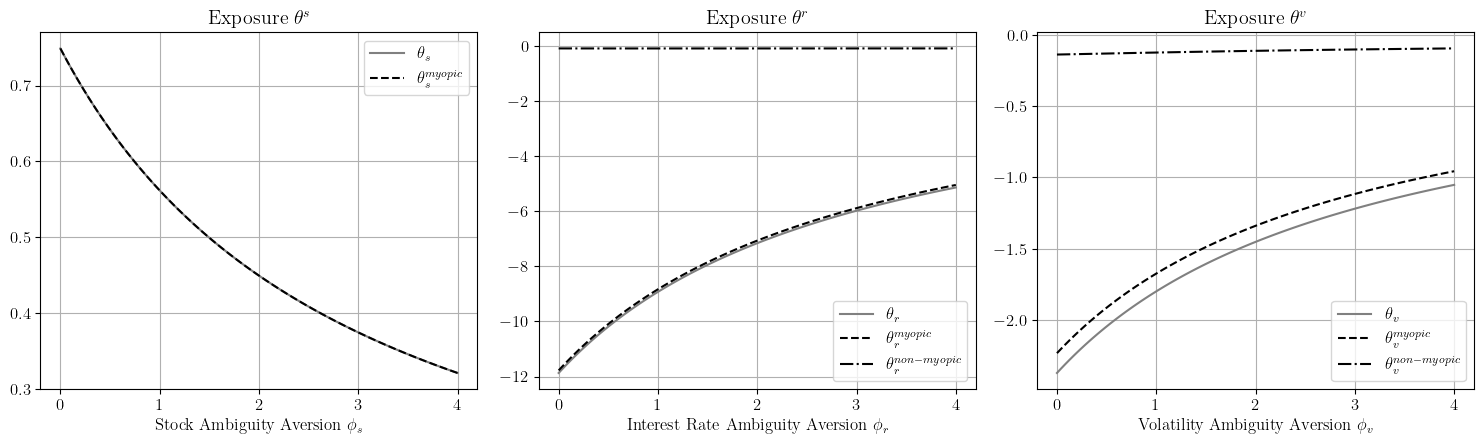

In [ ]:
# Plot results: only plot the theta corresponding to the phi being swept
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)

for ax, param_name in zip(axs, sweep_config.keys()):
    vals = results[param_name]["vals"]
    theta_key = f"theta_{param_name[-1]}"  # extracts 's', 'r', or 'v'

    # Plot the main theta
    ax.plot(vals, results[param_name][theta_key], **style_dict[theta_key])

    # Plot myopic and nonmyopic components if applicable
    if param_name == "phi_v":
        ax.plot(vals, results[param_name]["theta_v_myopic"], **style_dict["theta_v_myopic"])
        ax.plot(vals, results[param_name]["theta_v_nonmyopic"], **style_dict["theta_v_nonmyopic"])
    elif param_name == "phi_r":
        ax.plot(vals, results[param_name]["theta_r_myopic"], **style_dict["theta_r_myopic"])
        ax.plot(vals, results[param_name]["theta_r_nonmyopic"], **style_dict["theta_r_nonmyopic"])
    elif param_name == "phi_s":
        ax.plot(vals, results[param_name]["theta_s_myopic"], **style_dict["theta_s_myopic"])

    ax.set_title(sweep_config[param_name][2])
    ax.set_xlabel(sweep_config[param_name][1])
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Theta_ambiguity_2.png", dpi=600)
plt.show()

In [18]:
k1_v, k2_v, k3_v = compute_k1_k2_k3_vol_ambiguity(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j, 2, 2)
k1_r, k2_r, k3_r = compute_k1_k2_k3_rate_ambiguity(gamma, lambda_r, sigma_r, kappa_r, 2)

theta_s, theta_v, theta_r, theta_N, _, _, _, _, _ = theta_cal_ambiguity(
            gamma, lambda_s, lambda_v, lambda_r,
            sigma_v, sigma_r,
            k1_r, k2_r, k3_r,
            k1_v, k2_v, k3_v,
            mu, lambda_j, lambda_j_q, tau,
            2, 2, 2
        )

pi_calc(theta_s, theta_v, theta_r, theta_N
        , 0, 0, 0, 0, 0, 0, 0, 0, T_tilde, t_curr, kappa_r, lambda_r, mu, rho, nu)



(-3.9408195348756236, 1.1425038964389327, 0.0, 0.0, 3.7983156384366916)

In [19]:
# Arrays for parameter variations
pi_s_vals     = np.linspace(0, 4, 50)   
pi_r_vals     = np.linspace(0, 4, 50)   
pi_v_vals     = np.linspace(0, 4, 50)    


In [ ]:
# Style dict for plotting
style_dict = {
    "expected_X_opt": {"color": "black", "linestyle": "-"},
    "expected_X_6040": {"color": "red", "linestyle": ":"},
    "expected_X_ambiguity": {"color": "green", "linestyle": "-."},
}

# Parameter sweep setup
sweep_config = {
    "phi_s": (pi_s_vals, r"$\phi_s$", r"Stock Ambiguity Aversion $\phi_s$"),
    "phi_r": (pi_r_vals, r"$\phi_r$", r"Interest Rate Ambiguity Aversion $\phi_r$"),
    "phi_v": (pi_v_vals, r"$\phi_v$", r"Volatility Ambiguity Aversion $\phi_v$"),
}

# Initialize results
results = {}

S_base, V_base, r_base, M_base, B_base, dW_s_base, dW_v_base, dW_r_base, N_J_base = simulation(S0, V0, r0, dW_r, dW_v, dW_s, N_J)

# Sweep through each phi parameter
for param_name, (param_vals, _, title) in sweep_config.items():
    expected_X_opt = []
    expected_X_6040 = []
    expected_X_ambiguity = []
    exp_6040_ambiguity = []

    for val in tqdm(param_vals, desc=f"Sweeping {param_name}"):
        # Override the relevant phi value
        phi_s_val = val if param_name == "phi_s" else 0
        phi_r_val = val if param_name == "phi_r" else 0
        phi_v_val = val if param_name == "phi_v" else 0

        tau = 1/12

        X_opt, X_6040 = simulate_wealth(
            S_base, V_base, r_base, M_base, B_base,
            dW_s_base, dW_v_base, dW_r_base, N_J_base
        )
        
        expected_X_opt.append(X_opt.mean())
        expected_X_6040.append(X_6040.mean())
        S_amb, V_amb, r_amb, M_t_amb, B_amb, dW_s_amb_2, dW_v_amb_2, dW_r_amb_2, N_J_amb = simulate_paths_ambiguity(S0, V0, r0, phi_v_val, phi_r_val, phi_s_val, dW_r, dW_v, dW_s, N_J)

        X_ambiguity, X_amb_6040 = simulate_wealth_ambiguity(
            S_amb, V_amb, r_amb, M_t_amb, B_amb, dW_s_amb_2, dW_v_amb_2, dW_r_amb_2, N_J_amb, phi_s_val, phi_v_val, phi_r_val)
        
        expected_X_ambiguity.append(X_ambiguity.mean())
        exp_6040_ambiguity.append(X_amb_6040.mean())    

    results[param_name] = {
        "vals": param_vals,
        "opt": expected_X_opt,
        "6040": exp_6040_ambiguity,
        "ambiguity": expected_X_ambiguity
    }



Sweeping phi_v: 100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


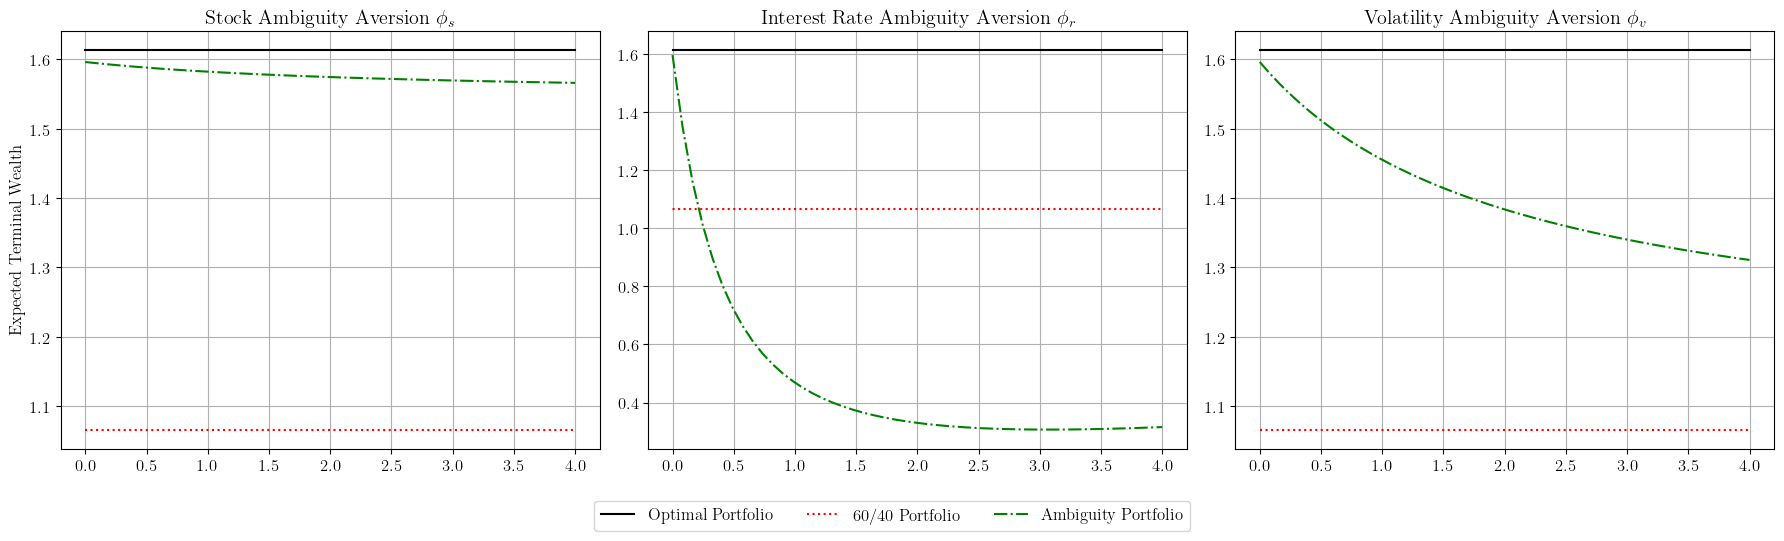

In [21]:
# Plot results: all 3 wealth curves for each phi sweep
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3)

# Plotting each subplot
for i, (ax, param_name) in enumerate(zip(axs, sweep_config.keys())):
    x_vals = results[param_name]["vals"]
    ax.plot(x_vals, results[param_name]["opt"], label="Optimal Portfolio", **style_dict["expected_X_opt"])
    ax.plot(x_vals, results[param_name]["6040"], label="60/40 Portfolio", **style_dict["expected_X_6040"])
    ax.plot(x_vals, results[param_name]["ambiguity"], label="Ambiguity Portfolio", **style_dict["expected_X_ambiguity"])
    ax.set_title(sweep_config[param_name][2])
    
    if i == 0:
        ax.set_ylabel("Expected Terminal Wealth", fontsize=12)
    else:
        ax.set_ylabel("")  # Remove y-axis label entirely

    ax.grid(True)

# Creating a single legend below the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)

plt.tight_layout()
plt.savefig("Wealth_ambiguity.png", dpi=600, bbox_inches='tight')
plt.show()
